# Attack on Diva using a Decision Tree

In this notebook I use the same dataset of the decision trees to build the shadow models

In [1]:
from pathlib import Path
import sys
from numba import njit

UTILS_RELATIVE_PATH = "../../../../"
sys.path.append(UTILS_RELATIVE_PATH)

MLEM_RELATIVE_PATH = "../../../../.."
sys.path.append(MLEM_RELATIVE_PATH)

LIME_RELATIVE_PATH = "../../../../../lime/"
sys.path.append(LIME_RELATIVE_PATH)

OUTPUT_FOLDER = Path("experiment_output")
OUTPUT_FOLDER.mkdir(exist_ok=True)

import logging
logging.disable('DEBUG')


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
import numpy as np
import scipy.spatial.distance as distance
import multiprocessing

np.random.seed(4321)
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer # type: ignore
from mlem.utilities import generate_balanced_dataset, save_pickle_bz2, load_pickle_bz2, save_txt

importing the experiment utilities and the mlem module

# Loading the Diva data

loading the Diva RandomForest and the dictionary with all the useful data

In [3]:
from utils.dataloading.diva import load_diva_data, load_diva_randomforest # type: ignore

BB = load_diva_randomforest()
BB_DATA = load_diva_data()

print(classification_report(BB_DATA['y_test'], BB.predict(BB_DATA['X_test'])))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2094
           1       0.85      0.77      0.81       745

    accuracy                           0.90      2839
   macro avg       0.89      0.86      0.87      2839
weighted avg       0.90      0.90      0.90      2839



In [4]:
print(*BB_DATA.keys())

X_train y_train X_test y_test X_validation y_validation X_validation_noisy y_validation_noisy X_attack_5_per_quantile y_attack_5_per_quantile categorical_features numerical_features categorical_features_mask centroids


# Creating the explainer

In [5]:
explainer_training_data = BB_DATA['X_train']
explainer = LimeTabularExplainer(training_data=explainer_training_data, categorical_features=[i for (i, el) in enumerate(BB_DATA['categorical_features_mask']) if el], random_state=123)

def generate_data_lime(x, num_samples):
    return explainer.data_inverse(x, num_samples+1, 'gaussian')[1][1:]

def filter_elements_std(elems, x, std=3):
    df_ = pd.DataFrame(elems)
    df_['Dist'] = distance.cdist(elems, [x])
    mean = df_.Dist.mean()
    dev = df_.Dist.std()
    closest = df_[df_['Dist'] < mean+std*dev]
    return closest.drop(labels=['Dist'], axis=1)

# Generating the lime datasets

In [6]:
test_representatives_x = BB_DATA['X_attack_5_per_quantile']
test_representatives_y = BB_DATA['y_attack_5_per_quantile']
n_datasets = len(test_representatives_x)

In [7]:
def generate_and_save(index, instance):
    # wrapper of the above functions to be able to generate the datasets in parallel
    output_path = OUTPUT_FOLDER / f"{index}"
    output_path.mkdir(exist_ok=True)
    balanced_dataset = generate_balanced_dataset(instance, 5000, BB, generate_data_lime, filter_elements_std)
    balanced_dataset.to_csv(output_path / "lime_generated.csv", index=False)
    with open(output_path / "instance.npy", "wb") as f:
        np.save(f, instance)


if not any([Path(OUTPUT_FOLDER / f"{j}" / "lime_generated.csv").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(processes=8) as pool:
        pool.starmap(generate_and_save, [*enumerate(test_representatives_x)])
else:
    print("The lime generated datasets already exist")

# Creating the Decision Trees

Creating the decision trees <span style="color:red"> if they don't already exist </span>.

In [8]:
from mlem.utilities import create_decision_tree

def train_decision_tree(datapath, model_name):
    lime_dataset = pd.read_csv(datapath / "lime_generated.csv")
    X_train, X_test, y_train, y_test = train_test_split(lime_dataset.drop('Target', axis=1).to_numpy(), lime_dataset.Target.to_numpy(), test_size=0.33, random_state=42)
    model_path = datapath / model_name
    if not model_path.exists():
        dt = create_decision_tree(X_train, y_train, use_halving=True) 
        save_pickle_bz2(model_path, dt)
        save_txt(datapath / "dt_classification_report.txt", classification_report(y_test, dt.predict(X_test)))

In [9]:
models_name = "dt.bz2"
if not any([Path(OUTPUT_FOLDER / f"{j}" / "dt.bz2").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(8) as pool:
        pool.starmap(train_decision_tree, [(Path(OUTPUT_FOLDER / f"{i}"), models_name) for i in range(len(test_representatives_x))])
else:
    print("The DecisionTrees already exist")

/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/joblib/parallel.py:735: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/joblib/parallel.py:735: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/joblib/parallel.py:735: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/joblib/parallel.py:735: UserWarning: Loky-backed parallel loops cannot be 

# Attack on the Decision Trees to create the attack models

Attack on the decision trees using the <span style="background: green">noisy dataset</span> labeled by the decision trees to create the shadow models.

In [10]:
categorical_features_mask = BB_DATA['categorical_features_mask']

Creating the shadow models and the attack models.

In [11]:
from mlem.shadow_models import ShadowModelsManager
from mlem.utilities import create_adaboost
from mlem.attack_models import AttackModelsManager, AttackStrategy

In [12]:
def compute_statistics_local_model(dataset, true_y, local_model, black_box, output_folder, filename):
    local_y = local_model.predict(dataset.to_numpy())
    local_bb = black_box.predict(dataset.to_numpy())

    report_local = classification_report(true_y.to_numpy(), local_y)
    report_bb    = classification_report(true_y.to_numpy(), local_bb)

    fidelity = str(pd.DataFrame(local_y == local_bb).value_counts(normalize=True))

    with open(output_folder / filename, "w") as f:
        f.write("Statistics on the noisy validation dataset\n")
        
        f.write("local model\n")
        f.write(report_local)

        f.write("\nblack box\n")
        f.write(report_bb)

        f.write("\nFidelity between the local model and the black box\n")
        f.write(fidelity)

Run the attack only if it hasn't already been run

In [20]:
if not any([(OUTPUT_FOLDER / f"{i}" / "attack").exists() for i in range(len(test_representatives_x))]):
    
    for path in [OUTPUT_FOLDER / f"{i}" for i in range(len(test_representatives_x))]:
        # load the local tree and label the noisy dataset
        local_tree = load_pickle_bz2(path / "dt.bz2")

        lime_dataset = pd.read_csv(path / "lime_generated.csv")
        lime_dataset_x = lime_dataset.drop('Target', axis=1)
        lime_dataset_y = lime_dataset.Target

        # compute fidelity and performances on the noisy dataset.
        # NOTE: The labels associated with the noisy dataset are the same of the clean one.
        compute_statistics_local_model(lime_dataset_x, lime_dataset_y, local_tree, BB, path, "statistics_limegenerated.txt")

        x_attack = lime_dataset_x.to_numpy()    
        y_attack = local_tree.predict(x_attack)

        path_shadow = str(path / "shadow")

        shadow_models = ShadowModelsManager(
            n_models=4,
            results_path=path_shadow,
            test_size=0.5,
            random_state=123,
            model_creator_fn=create_adaboost,
            categorical_mask=categorical_features_mask
        )
        # x_attack is the noisy dataset
        shadow_models.fit(x_attack, y_attack)

        # extracting the dataset for the attack models
        attack_models_dataset = shadow_models.get_attack_dataset()

        # saving the attack dataset
        attack_models_dataset.to_csv(path / "attack_models_train_dataset.csv", index=False)

        # Creating the attack model for each label using Adaboost
        path_attack = str(path / "attack")
        attack_models = AttackModelsManager(
                results_path=path_attack, model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
        )
        
        attack_models.fit(attack_models_dataset)
else:
    print("The attack models already exist")

The attack models already exist


By looking at the test reports of the attack models, it seems that they <span style="background: red">perform bad on both classes</span> with an accuracy of $\simeq .50$

# Creating the ensembles

In [21]:
from mlem.ensemble import HardVotingClassifier, SoftVotingClassifier, KMostSureVotingClassifier
from utils.attack_evaluation import evaluate_attack

In [22]:
attack_models_0 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "0" / "model.pkl.bz2") for i in range(len(test_representatives_x))]
attack_models_1 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "1" / "model.pkl.bz2") for i in range(len(test_representatives_x))]

## Hard Voting

In [23]:
hv0 = HardVotingClassifier(classifiers=attack_models_0)
hv1 = HardVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.65      0.06      0.12      6542
         out       0.30      0.92      0.45      2796

    accuracy                           0.32      9338
   macro avg       0.47      0.49      0.28      9338
weighted avg       0.54      0.32      0.22      9338


Class 0
              precision    recall  f1-score   support

          in       0.64      0.06      0.11      4899
         out       0.30      0.93      0.45      2128

    accuracy                           0.32      7027
   macro avg       0.47      0.49      0.28      7027
weighted avg       0.54      0.32      0.21      7027


Class 1
              precision    recall  f1-score   support

          in       0.65      0.08      0.15      1643
         out       0.28      0.89      0.43       668

    accuracy                           0.32      2311
   macro avg       0.47      0.49      0.29      2311
weighted avg       0.55      0.32      0.23 

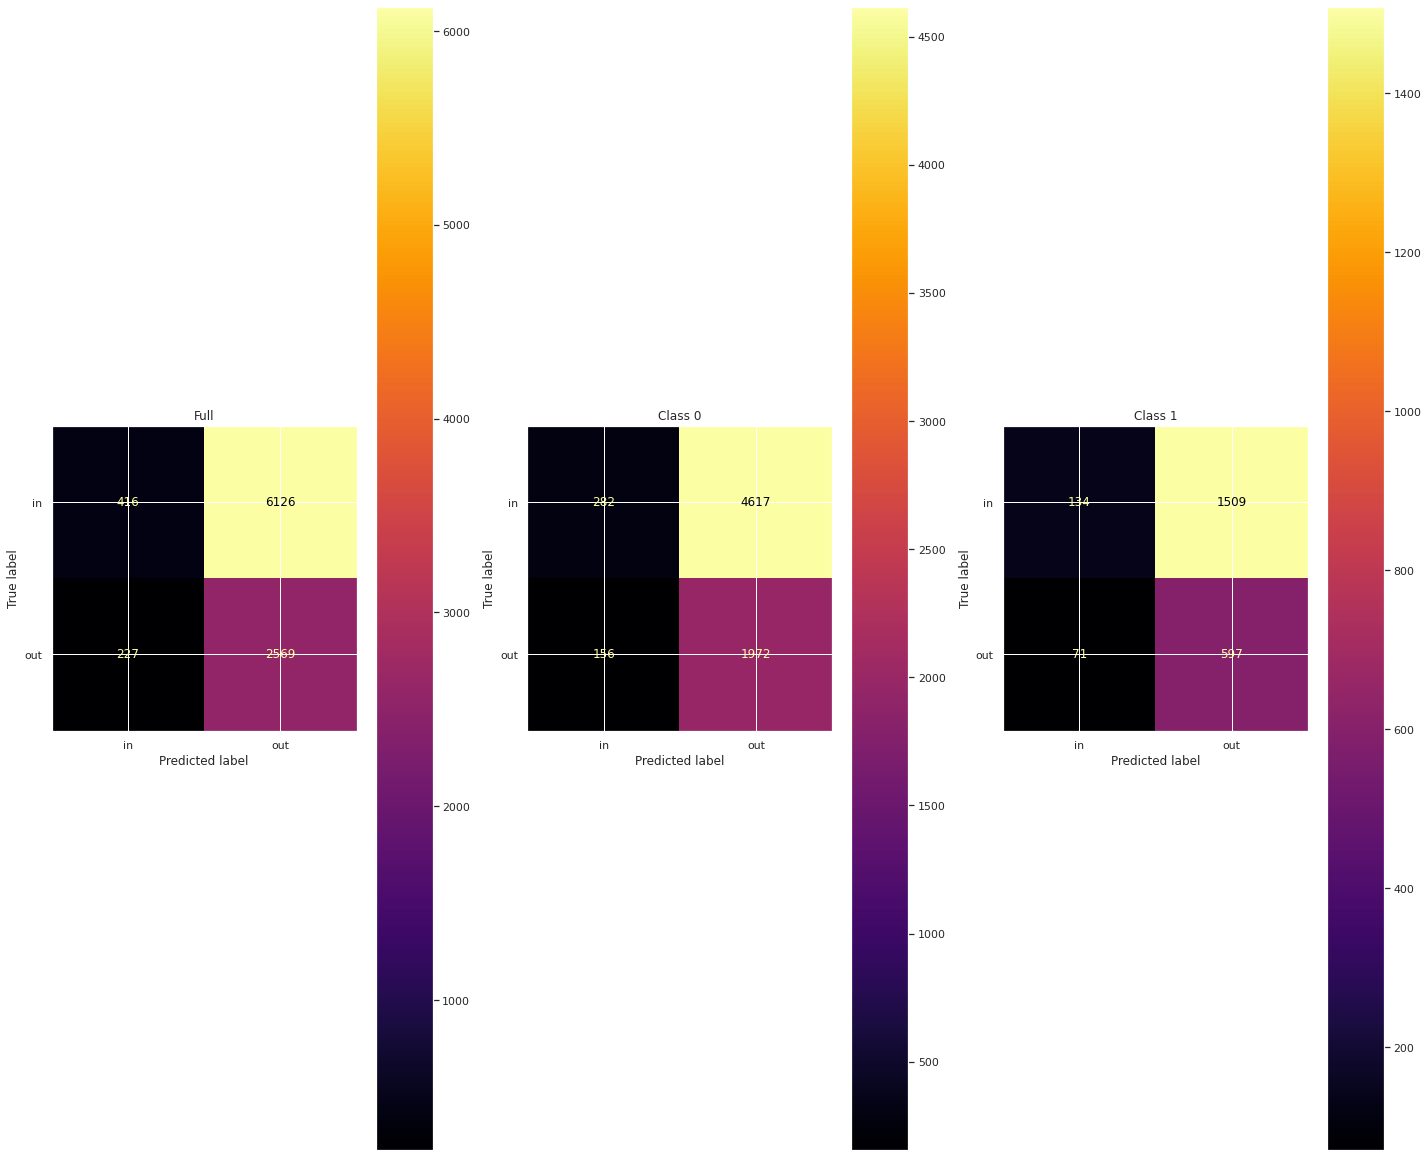

In [24]:
evaluate_attack(hv0, hv1, BB, BB_DATA)

## Soft Voting

In [25]:
sv0 = SoftVotingClassifier(classifiers=attack_models_0)
sv1 = SoftVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.65      0.05      0.10      6624
         out       0.30      0.93      0.45      2839

    accuracy                           0.32      9463
   macro avg       0.47      0.49      0.28      9463
weighted avg       0.55      0.32      0.21      9463


Class 0
              precision    recall  f1-score   support

          in       0.64      0.04      0.08      4965
         out       0.30      0.95      0.46      2165

    accuracy                           0.32      7130
   macro avg       0.47      0.49      0.27      7130
weighted avg       0.54      0.32      0.19      7130


Class 1
              precision    recall  f1-score   support

          in       0.66      0.09      0.17      1659
         out       0.28      0.88      0.43       674

    accuracy                           0.32      2333
   macro avg       0.47      0.49      0.30      2333
weighted avg       0.55      0.32      0.24 

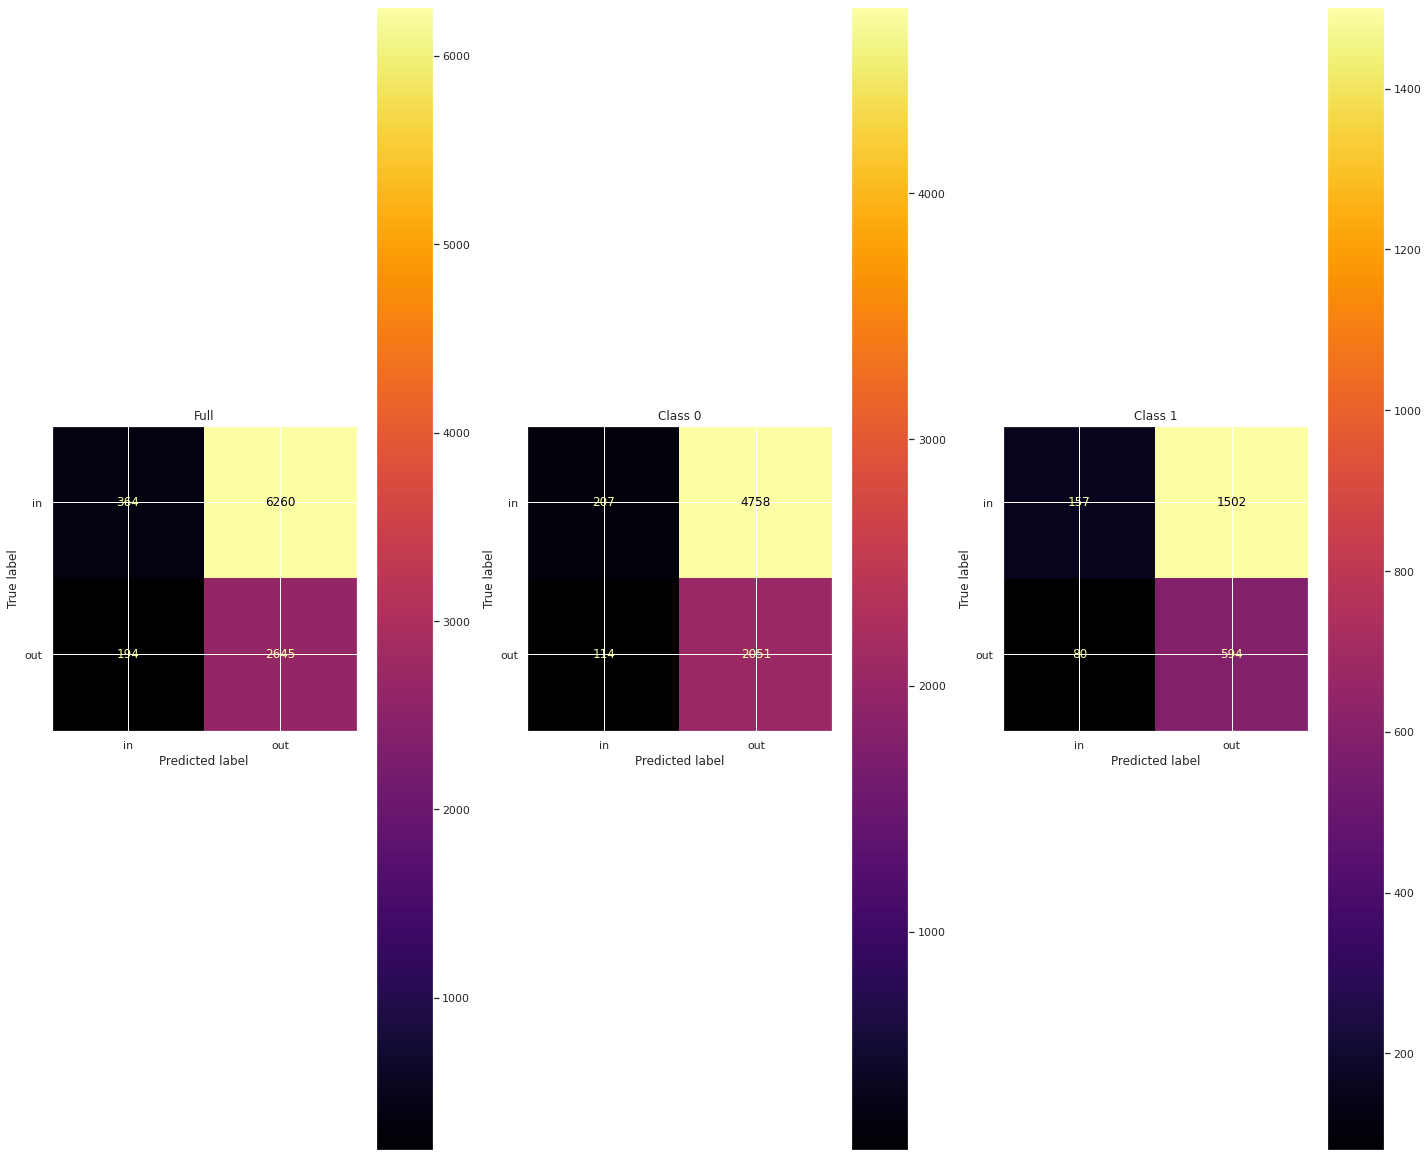

In [26]:
evaluate_attack(sv0, sv1, BB, BB_DATA)